# Portfolio 4

## The Scheduling Problem as a Graph Colouring Problem

It is possible to solve a scheduling problem as a graph colouring problem. 
We generate artificial data for a scheduling problem, express it in terms of graph colouring, and use a greedy algorithm to approximate a solution.

## Problem Statement

We consider the problem of exam scheduling, which was examined in lecture on Feb 14.  
Final exams are being scheduled into different timeslots. Each course must have an exam.
However, each student can only write one exam per timeslot.
The task is to find a schedule that minimizes the number of timeslots needed to schedule all exams.  
Unlike the formulation in lecture, we do not consider the problem of students writing exams back-to-back.

## Formulation as a Graph Colouring Problem

**Parameters:**
* There are $m$ courses that need to have exams scheduled.
* There are $n$ students taking these courses.
* There are $s$ available time slots for exams.
* We have a matrix $C = [c_{ij}]$ where $c_{ij} = 1$ if student $i$ is registered in course $j$.

We use the matrix $C$ to construct an adjacency matrix $A$ corresponding to our graph.  
Each node in the graph corresponds to the corresponding row and column in the adjacency matrix.  
$A = [a_{j,j'}]$ where $a_{j,j'} = 1$ if there is some student taking both course $j$ and course $j'$, and 0 otherwise.

**Decision Variables**:
Let $x_{j} = k$, where $k \in \{0, \dots s-1\}$ is the timeslot that course $j$ is scheduled in.
In the graph coloring formulation, this corresponds to the colour of node $j$.
We are not using integer programming here, so it is not necessary to restrict the variables to be 0 or 1, and this formulation allows us to more directly see what each element corresponds to in the graph.
However, we will need to modify this to compare our result with an exact solution computed by integer programming.

**Objective**
Minimize the number of timeslots (colours) used: $\min \max_j x_j + 1$  
We use colours sequentially and represent them as numbers starting from 0, so the number of colours used is exactly 1 more than the maximum "colour".

**Constraints:**
* Each course must have one exam scheduled.
In the graph, this is represented by the fact that every node must have a unique colour.
* Each student can only write at most one exam per timeslot.  
In the graph, this is represented by the fact that two nodes share an edge if at least one student is registered in both, and nodes that share an edge cannot have the same colour.

## Implementing the Greedy Algorithm

We attempt to use a greedy algorithm to implement the graph colouring.
The `networkx` package provides a `greedy_color` function that does this.  
The Wikipedia article on "Greedy coloring" provides some sample Python code, but it does not work for our particular adjacency matrix formulation.  
To better improve our understanding, we will try to implement the algorithm ourselves.  

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Specify parameter values:

In [3]:
s = 20
n = 100
m = 20

We reuse some code from the lecture on Feb 14 to generate some fake data.  

For a more realistic situation, we suppose that some courses are more popular than others.
We suppose that students are more likely to take one of the first four courses than the other 16.
Below, we suppose that the probability of a student taking one of the first four courses is 12.5%, and the probability of a student taking any of the other 16 courses is 3.125%.

In [7]:
C = np.zeros((n,m))
maxcourses = 6
for i in range(n):
    generator = np.random.default_rng(seed=234442047089537783695512289678818298668+i)
    ncourses = generator.integers(1,maxcourses+1)
    # non-uniform probabilities
    p = np.ones(m) * 0.03125
    p[range(4)] = 0.125 # probability 0.5 to be in first 4 courses
    js = generator.choice(range(m),size=ncourses,replace=False,p=p)
    C[i,js] = 1.

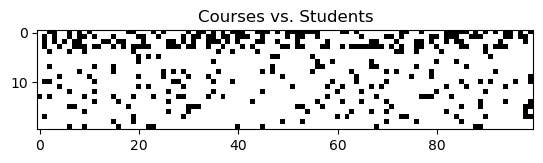

In [8]:
plt.imshow(C.T,cmap='binary'), plt.title("Courses vs. Students")
plt.show()

Set up the adjacency matrix.

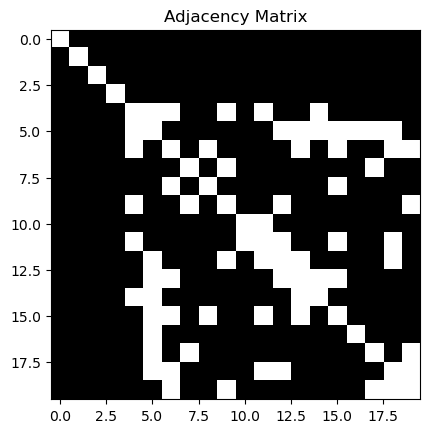

In [9]:
A = np.zeros((m,m))

for j1 in range(m):
    for j2 in range(j1+1,m): # check only un-checked combinations
        # check if they share a student
        if C[:,j1].T @ C[:,j2] >= 1: # share a student
            A[j1,j2] = 1
            A[j2,j1] = 1

plt.imshow(A,cmap='binary'), plt.title("Adjacency Matrix")
plt.show()

To implement the greedy algorithm, we iterate over the nodes and colour each with the smallest colour not used by its neighbours.

In [38]:
def get_colour(adj, clr, j, s):
    # get the colour of node j based on adjacency matrix (adj), already coloured nodes (clr)
    j = int(j)
    neighbours = np.bool_(adj[:,j])
    nbr_clrs = clr[neighbours]
    for k in range(s):
        # iterate through possible colours and 
        if k not in nbr_clrs: return k
            
    return None # indicate that no suitable colour could be found

def greedy_colour(adj, s, order):
    # do a greedy colouring of the graph, checking the vertices in the specified order
    _, m = adj.shape
    colours = np.ones(m) * -1 # use -1 to represent uncoloured vertices
    for j in order:
        colour = get_colour(adj, colours, j, s)
        if colour == None:
            print(f'No valid colouring with at most {s} colours found.')
            return None
        else:
            colours[j] = colour
    return colours

The order that the vertices are visited matters to the algorithm.
Kosowski and Manuszewski (2004) describe a number of strategies for ordering the vertices.
This paper is also the source cited by `networkx` for its own implementation of these strategies using `greedy_color`.

First, we try the "naive" strategy, Random Sequential: we visit the vertices in a random order.

In [21]:
rs_order = np.random.default_rng(seed=234442047089537783695512289678818298668).permutation(range(m))
print(rs_order)
greedy_colour(A,s,rs_order)

[19 16  5 10 11 18  0 13 15  1  4  3  2 12  8  7 14  6 17  9]


array([ 3.,  5.,  8.,  7.,  6.,  1.,  0., 11., 10.,  9.,  2.,  2.,  9.,
        4.,  6.,  4.,  1., 11.,  0.,  0.])

The greedy colouring finds a solution that uses 11 timeslots.  
However, this naive approach often does not return a good colouring.
We can modify the function slightly to instead check the vertices in order of decreasing degree - Kosowski and Manusewski term this the "largest first" strategy.

In [22]:
def greedy_colour_lf(adj, s):
    # get vertices in order of degree
    deg = np.sum(adj,axis=0)
    deg_sort = np.flip(np.argsort(deg)) # largest to smallest
    return greedy_colour(adj, s, deg_sort)

In [23]:
greedy_colour_lf(A, s)

array([ 0.,  1.,  2.,  3.,  8.,  4.,  6.,  7.,  6.,  9.,  5.,  5., 10.,
       11.,  8.,  6.,  4.,  7., 10.,  9.])

In this particular case, ordering the vertices does not improve the result; we still need 11 colours.
For this artificial example, the degrees of the vertices are all fairly large, so checking the highest degree vertices first is unlikely to produce much of an improvement. 

We can attempt one more adjustment - the "smallest last" method. This entails iteratively removing the smallest degree vertex from the graph, and then checking the vertices in the reverse of the resulting sequence.

In [40]:
def greedy_colour_sl(adj,s):
    _, m = adj.shape
    V = adj.copy()
    orig_idx = np.arange(m) # vertices of the original graph
    K = np.ones(m) * np.inf # using array of inf as placeholder
    for j in range(m):
        # get smallest degree vertex
        deg = np.sum(V,axis=0)
        small_deg = np.argmin(deg)
        K[j] = orig_idx[small_deg] # get the index of the original graph
        # remove small_deg from V
        V = np.delete(V, small_deg, axis=0)
        V = np.delete(V, small_deg, axis=1)
        orig_idx = np.delete(orig_idx, small_deg)
    return greedy_colour(adj, s, np.flip(np.int32(K)))

In [41]:
greedy_colour_sl(A, s)

array([10.,  9.,  8.,  7.,  3.,  1.,  0.,  6.,  2., 11.,  5.,  5.,  4.,
        4.,  3.,  2.,  1.,  6.,  0.,  0.])

The smallest last method gives the same number of timeslots as the other two methods.  
From this, we can guess that 11 is the true minimum number of timeslots needed for this data.  
The reason all three versions give the same result may be because all the nodes have fairly large degree, meaning there are only a very limited number of ways to colour the graph.

## References

"Greedy coloring". *Wikipedia*, Wikimedia Foundation, https://en.wikipedia.org/wiki/Greedy_coloring. Accessed 22 Mar 2024.

Kosowski, Adrian and Krzysztof Manuszewski. "Classical Coloring of Graphs". *Graph Colorings*, edited by Marek Kubale, The American Mathematical Society, 2004, pp. 2-19. https://doi.org/10.1090/conm/352

Walls, Patrick. "Scheduling Exams". Math 441. Mathematical Modelling: Discrete Optimization Problems. 14 February 2024, University of British Columbia. Lecture.